## DATA 620 

---
### Project 1 - Alt
### Mael Illien and Jeremy OBrien

* Identify and load a network dataset that has some categorical information available for each node.
* For each of the nodes in the dataset, calculate degree centrality and eigenvector centrality.
* Compare your centrality measures across your categorical groups.
* For example, using the dataset from a study of romantic relationships among high school students in Columbus, Ohio [http://researchnews.osu.edu/archive/chains.htm], you might want to determine if there are any differences in your calculated centrality measures between the two sexes. You might use a t-test or another statistical measure to support your findings.


In [1]:
import csv
import foursquare
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from config import foursquare_config as fs_config
%matplotlib inline

## Data Import

In [2]:
midtown_raw = pd.read_csv('venues_midtown_unique.csv')
downtown_raw = pd.read_csv('venues_downtown.csv')
westvil_raw = pd.read_csv('venues_westvil_unique.csv')

In [4]:
# Cleanup datasets
midtown = midtown_raw.filter(items=['id', 'name','type'])
downtown = downtown_raw.drop_duplicates()
downtown = downtown.filter(items=['id', 'name','type'])
#downtown = downtown.reset_index()
westvil = westvil_raw.filter(items=['id', 'name','type'])

In [132]:
# Combine the 3 venues data frames into one
venues = midtown
venues = venues.append(westvil, ignore_index=True)
venues = venues.append(downtown, ignore_index=True)
venues = venues.drop_duplicates()
venues = venues.reset_index(drop=True)

print("Working with {} venues".format(len(venues)))
venues.head()

Working with 65 venues


,id,name,type
0,43695300f964a5208c291fe3,Empire State Building,Building
1,4bcca12bb6c49c7422169491,86th Floor Observation Deck,Scenic Lookout
2,49b7ed6df964a52030531fe3,Times Square,Plaza
3,41102700f964a520d60b1fe3,Macy's,Department Store
4,40b68100f964a5207d001fe3,Madison Square Park,Park


## Data Processing

We proceed to refine the categorical variable type into fewer categories for downstream analysis.

In [133]:
venues['category'] = None

foods = ['Food Court','Theme Restaurant','Burgers','Gourmet',"Farmer's Market", 'Coffee Shop', 'Falafel', 
         'Beer Garden','Pizza','Food Court', 'Grocery Store', 'New American','American']
shops = ['Department Store', 'Candy Store', 'Toys & Games', 'Bookstore','Market','Electronics','Cosmetics',
         'Wine Shop','Comic Shop','Mall']
entertainment = ['Basketball','Indie Movies','Performing Arts','Art Museum','Movie Theater','Dog Run']
tourist = ['Building','Scenic Lookout','Plaza','Park','Fountain','Outdoor Sculpture',' Memorial Site',
           'Bridge','Landmark','Historic Site','Island','Memorial Site']

for i in range(len(venues)):
    venue_type = venues['type'][i]
    if venue_type in foods:
        venues['category'][i] = 'Food and Beverage'
    elif venue_type in shops:
        venues['category'][i] = 'Shopping'
    elif venue_type in entertainment:
        venues['category'][i] = 'Entertainment'
    elif venue_type in tourist:
        venues['category'][i] = 'Tourist Attraction'
    else:
        venues['category'][i] = 'Other'      

In [135]:
venues.head()

,id,name,type,category
0,43695300f964a5208c291fe3,Empire State Building,Building,Tourist Attraction
1,4bcca12bb6c49c7422169491,86th Floor Observation Deck,Scenic Lookout,Tourist Attraction
2,49b7ed6df964a52030531fe3,Times Square,Plaza,Tourist Attraction
3,41102700f964a520d60b1fe3,Macy's,Department Store,Shopping
4,40b68100f964a5207d001fe3,Madison Square Park,Park,Tourist Attraction


## Generate network

To generate the network, we read and append the links contained in csv files for each of the neighborhoods of interest. We use these links to generate edges. We also iterate over the nodes to enter their attributes.

In [13]:
def generate_network(venues, link_files):
    # Read links from file which are stored a str representation of tuples
    links = []
    for lf in link_files:
        with open(lf, newline='') as f:
            reader = csv.reader(f)
            for row in reader:
                as_tpl = eval(row[0])
                links.append(as_tpl)
    
    # Create graph
    G = nx.DiGraph()
    for f, t in links:
        G.add_edge(f, t)
        
    # Add attributes to the nodes
    for i in range(len(venues)):
        ven_id = venues['id'][i]
        G.nodes[ven_id]['name'] = venues['name'][i]
        G.nodes[ven_id]['category'] = venues['category'][i]
    # Trim nodes of degree 1 or less
    #small = [n for n in G.nodes if G.degree[n] <= 1]
    #G.remove_nodes_from(small)
        
    return G

The returned graph contains an unexpected number of nodes. This is due to target venues that we were unable to acquire data for, so if kept, they would appear nameless and attributeless. There we proceed to remove those ndoes and get back the expected graph size. 

In [136]:
link_files = ['links_midtown.csv','links_westvil.csv','links_downtown.csv']
g = generate_network(venues, link_files)
print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 107
Number of edges: 245
Average in degree:   2.2897
Average out degree:   2.2897


In [137]:
# Identify and drop nodes that have no info
no_name = [node for node in g.nodes if node not in list(venues['id'])]
g.remove_nodes_from(no_name)
print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 65
Number of edges: 199
Average in degree:   3.0615
Average out degree:   3.0615


## Compute metrics

This section defines functions that compute the centrality measures of the graphs and breaks it down by categories.

In [16]:
def get_metrics(venues, graph):

    degree = nx.degree(graph)
    venues['degree'] = [degree[n] for n in venues['id']]
    pagerank = nx.pagerank(graph, alpha=.9)
    venues['pagerank'] = [pagerank[n] for n in venues['id']]
    betweenness = nx.betweenness_centrality(graph)
    venues['betweenness'] = [betweenness[n] for n in venues['id']]
    closeness = nx.closeness_centrality(graph)
    venues['closeness'] = [closeness[n] for n in venues['id']]
    
    return venues

In [53]:
metrics = get_metrics(venues, g)

The below dataframes contain the top five venues for each metric sorted in descending order regardless of category. 

#### Table 1: Top 5 venues by degree

In [143]:
metrics.sort_values(by=['degree'], ascending=False).head()
#metrics.sort_values(by=['degree'], ascending=False).tail()

,id,name,type,category,degree,pagerank,betweenness,closeness
2,49b7ed6df964a52030531fe3,Times Square,Plaza,Tourist Attraction,21,0.100207,0.071191,0.250164
44,4b6b5abff964a520fb022ce3,National September 11 Memorial & Museum (Natio...,Memorial Site,Tourist Attraction,19,0.053557,0.113659,0.237608
43,4abe7f9ef964a520068e20e3,One World Trade Center,Building,Tourist Attraction,15,0.036169,0.076209,0.191406
5,3fd66200f964a520d7f11ee3,Bryant Park,Park,Tourist Attraction,14,0.046678,0.053272,0.218033
15,3fd66200f964a520def11ee3,Union Square Park,Park,Tourist Attraction,13,0.017862,0.161632,0.244898


#### Table 2: Top 5 venues by pagerank

In [144]:
metrics.sort_values(by=['pagerank'], ascending=False).head()

,id,name,type,category,degree,pagerank,betweenness,closeness
2,49b7ed6df964a52030531fe3,Times Square,Plaza,Tourist Attraction,21,0.100207,0.071191,0.250164
44,4b6b5abff964a520fb022ce3,National September 11 Memorial & Museum (Natio...,Memorial Site,Tourist Attraction,19,0.053557,0.113659,0.237608
47,4a43bcb7f964a520bba61fe3,Brooklyn Bridge,Bridge,Tourist Attraction,13,0.053154,0.173723,0.186233
5,3fd66200f964a520d7f11ee3,Bryant Park,Park,Tourist Attraction,14,0.046678,0.053272,0.218033
9,49b79f54f964a5202c531fe3,Rockefeller Center,Plaza,Tourist Attraction,6,0.045355,0.000000,0.184230


#### Table 3: Top 5 venues by betweenness

In [21]:
metrics.sort_values(by=['betweenness'], ascending=False).head()

,id,name,type,category,degree,pagerank,betweenness,closeness
47,4a43bcb7f964a520bba61fe3,Brooklyn Bridge,Bridge,Tourist Attraction,13,0.053154,0.173723,0.186233
15,3fd66200f964a520def11ee3,Union Square Park,Park,Tourist Attraction,13,0.017862,0.161632,0.244898
17,40abf500f964a52035f31ee3,Washington Square Park,Park,Tourist Attraction,11,0.014721,0.152679,0.211765
56,4a32c3f9f964a5208c9a1fe3,Manhattan Bridge,Bridge,Tourist Attraction,5,0.011933,0.148797,0.120888
0,43695300f964a5208c291fe3,Empire State Building,Building,Tourist Attraction,12,0.024481,0.146280,0.198047


#### Table 4: Top 5 venues by closeness

In [142]:
metrics.sort_values(by=['closeness'], ascending=False).head()

,id,name,type,category,degree,pagerank,betweenness,closeness
2,49b7ed6df964a52030531fe3,Times Square,Plaza,Tourist Attraction,21,0.100207,0.071191,0.250164
15,3fd66200f964a520def11ee3,Union Square Park,Park,Tourist Attraction,13,0.017862,0.161632,0.244898
44,4b6b5abff964a520fb022ce3,National September 11 Memorial & Museum (Natio...,Memorial Site,Tourist Attraction,19,0.053557,0.113659,0.237608
5,3fd66200f964a520d7f11ee3,Bryant Park,Park,Tourist Attraction,14,0.046678,0.053272,0.218033
3,41102700f964a520d60b1fe3,Macy's,Department Store,Shopping,11,0.015229,0.078633,0.212193


The function below generate the top 5 values and names for each of the centrality measure and for each category.

In [95]:
measures = ['degree','pagerank','betweenness','closeness']

def category_centrality(metrics, display='values'):
    dfh = pd.DataFrame()
    cat_centrality = pd.DataFrame()
    categories = list(set(metrics.category))

    for cat in categories:
        ven = metrics[metrics['category'] == cat]
        
        dfh['category'] = [cat]*5 
        
        for measure in measures:
            
            top_5 = ven.sort_values(by=[measure], ascending=False).head()
            top_5 = top_5.filter(items=['name',measure])
            
            if display == 'names':
                dfh[measure] = list(top_5['name'])
            else:
                dfh[measure] = list(top_5[measure])
            
        cat_centrality =  cat_centrality.append(dfh)
        
    return cat_centrality

#### Top 5 centrality measure values for each category 

In [100]:
with_vals = category_centrality(metrics)
with_vals

,category,degree,pagerank,betweenness,closeness
0,Tourist Attraction,21,0.100207,0.173723,0.250164
1,Tourist Attraction,19,0.053557,0.161632,0.244898
2,Tourist Attraction,15,0.053154,0.152679,0.237608
3,Tourist Attraction,14,0.046678,0.148797,0.218033
4,Tourist Attraction,13,0.045355,0.146280,0.211765
0,Food and Beverage,9,0.034937,0.037078,0.206897
1,Food and Beverage,9,0.023213,0.029762,0.188482
2,Food and Beverage,8,0.013390,0.022073,0.181417
3,Food and Beverage,6,0.011312,0.021925,0.166667
4,Food and Beverage,6,0.010896,0.014757,0.166667


#### Top 5 centrality measure for each category with venue names

In [138]:
with_names = category_centrality(metrics,display='names')
with_names

,category,degree,pagerank,betweenness,closeness
0,Tourist Attraction,Times Square,Times Square,Brooklyn Bridge,Times Square
1,Tourist Attraction,National September 11 Memorial & Museum (Natio...,National September 11 Memorial & Museum (Natio...,Union Square Park,Union Square Park
2,Tourist Attraction,One World Trade Center,Brooklyn Bridge,Washington Square Park,National September 11 Memorial & Museum (Natio...
3,Tourist Attraction,Bryant Park,Bryant Park,Manhattan Bridge,Bryant Park
4,Tourist Attraction,Union Square Park,Rockefeller Center,Empire State Building,Washington Square Park
0,Food and Beverage,Union Square Greenmarket,Hard Rock Cafe,Hard Rock Cafe,Union Square Greenmarket
1,Food and Beverage,Whole Foods Market,Grimaldi's Pizzeria,Whole Foods Market,Whole Foods Market
2,Food and Beverage,Hard Rock Cafe,Le District,Union Square Greenmarket,Hard Rock Cafe
3,Food and Beverage,One Dine,Hudson Eats,Shake Shack,Think Coffee
4,Food and Beverage,Le District,Whole Foods Market,Le District,Starbucks


What we can learn from the table above is that while Times Square is the most connected node by a variety of measures. However, the Brooklyn bridge has a higher measure of betweenness, meaning that more users pass through that node.

## Statistical Test

With the help of statististics, let's verify whether these metrics are consistent between categorical groups first with the visual help of boxplots and second with ANOVA.

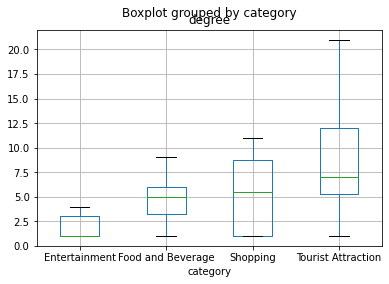

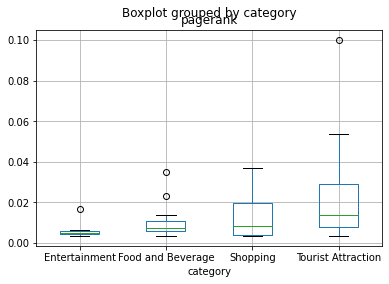

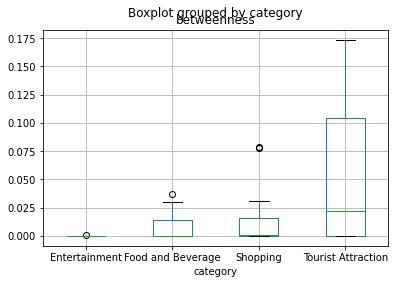

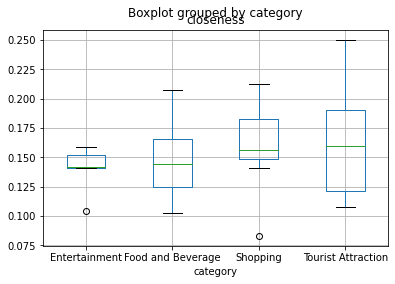

In [127]:
for measure in measures:
    metrics.boxplot(measure, by='category')

#### Analysis of variance 

In [118]:
mod = ols('degree ~ category',
                data=metrics).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

              sum_sq    df        F    PR(>F)
category  346.765079   3.0  7.71221  0.000189
Residual  914.250305  61.0      NaN       NaN


In [119]:
mod = ols('closeness ~ category',
                data=metrics).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

            sum_sq    df         F    PR(>F)
category  0.005444   3.0  1.413311  0.247533
Residual  0.078320  61.0       NaN       NaN


In [121]:
mod = ols('betweenness ~ category',
                data=metrics).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

            sum_sq    df         F   PR(>F)
category  0.031497   3.0  5.892221  0.00134
Residual  0.108693  61.0       NaN      NaN


In [122]:
mod = ols('pagerank ~ category',
                data=metrics).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

            sum_sq    df         F    PR(>F)
category  0.002508   3.0  3.277602  0.026873
Residual  0.015561  61.0       NaN       NaN


The analysis of variance tables reveal that we can reject the null hypothesis, which postulates that the means of the centrality measures across categories are the same, for all measures but closeness. This is not surprising given the closeness boxplot just above. From this we can conclude that regardless of category, nodes are on average equally close to all other nodes.

## Visualization

In [148]:
# Make figures bigger
plt.rcParams['figure.figsize'] = [20, 10]

In [150]:
labels = dict(zip(list(venues['id']),list(venues['name'])))
graph_pos = nx.spring_layout(g, k=0.5)

In [151]:
#[v['id'] for v in venues if v['category'] is 'foods'] 
fb_nodes = list(venues[venues['category'] == 'Food and Beverage']['id'])
sh_nodes = list(venues[venues['category'] == 'Shopping']['id'])
e_nodes = list(venues[venues['category'] == 'Entertainment']['id'])
t_nodes = list(venues[venues['category'] == 'Tourist Attraction']['id'])
o_nodes = list(venues[venues['category'] == 'Other']['id'])

In [162]:
# Plot network
def draw_network_with_colors():
    
    #fig = plt.figure(figsize(16,9), dpi=150)
    pagerank = nx.pagerank(g, alpha=.9)
    nodesize = [10000 * n for n in pagerank.values()]
    #nx.draw_networkx_nodes(g, graph_pos, node_size=nodesize, alpha=.5, node_color='blue')

    nx.draw_networkx_nodes(g, graph_pos, nodelist=fb_nodes, node_color='r', node_size=500, alpha=0.8)
    nx.draw_networkx_nodes(g, graph_pos, nodelist=sh_nodes, node_color='b', node_size=500, alpha=0.8)
    nx.draw_networkx_nodes(g, graph_pos, nodelist=e_nodes, node_color='orange', node_size=500, alpha=0.8)
    nx.draw_networkx_nodes(g, graph_pos, nodelist=t_nodes, node_color='green', node_size=500, alpha=0.8)
    nx.draw_networkx_nodes(g, graph_pos, nodelist=o_nodes, node_color='grey', node_size=500, alpha=0.8)

    #nx.draw_networkx_nodes(g, pos, nodelist=[4,5,6,7], node_color='b', node_size=500, alpha=0.8)
    nx.draw_networkx_edges(g, graph_pos, width=1, alpha=.3, edge_color='black')
    nx.draw_networkx_labels(g, graph_pos, labels=labels, font_size=10, font_family='Arial')

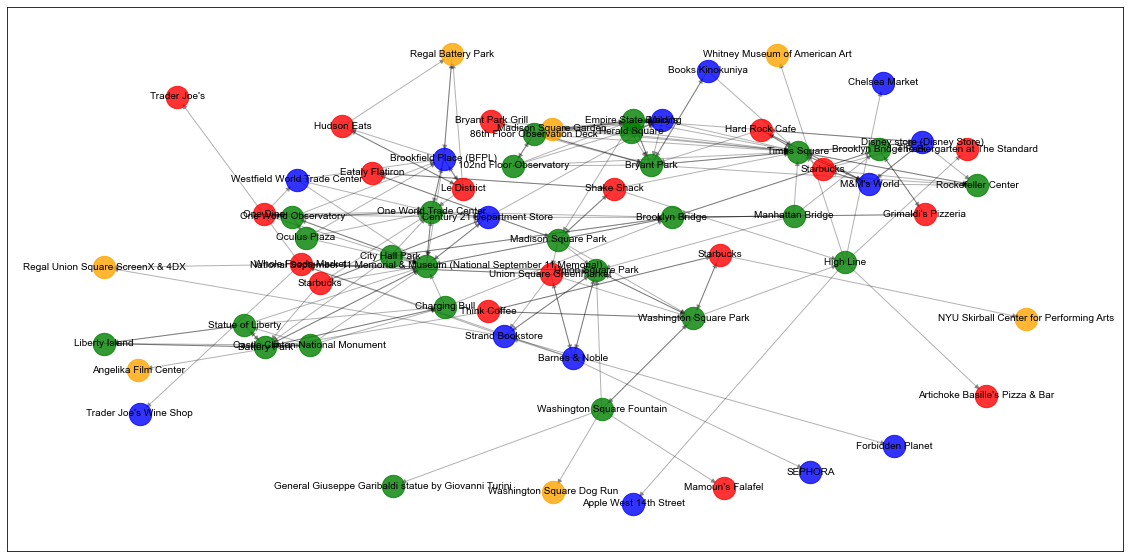

In [163]:
draw_network_with_colors()

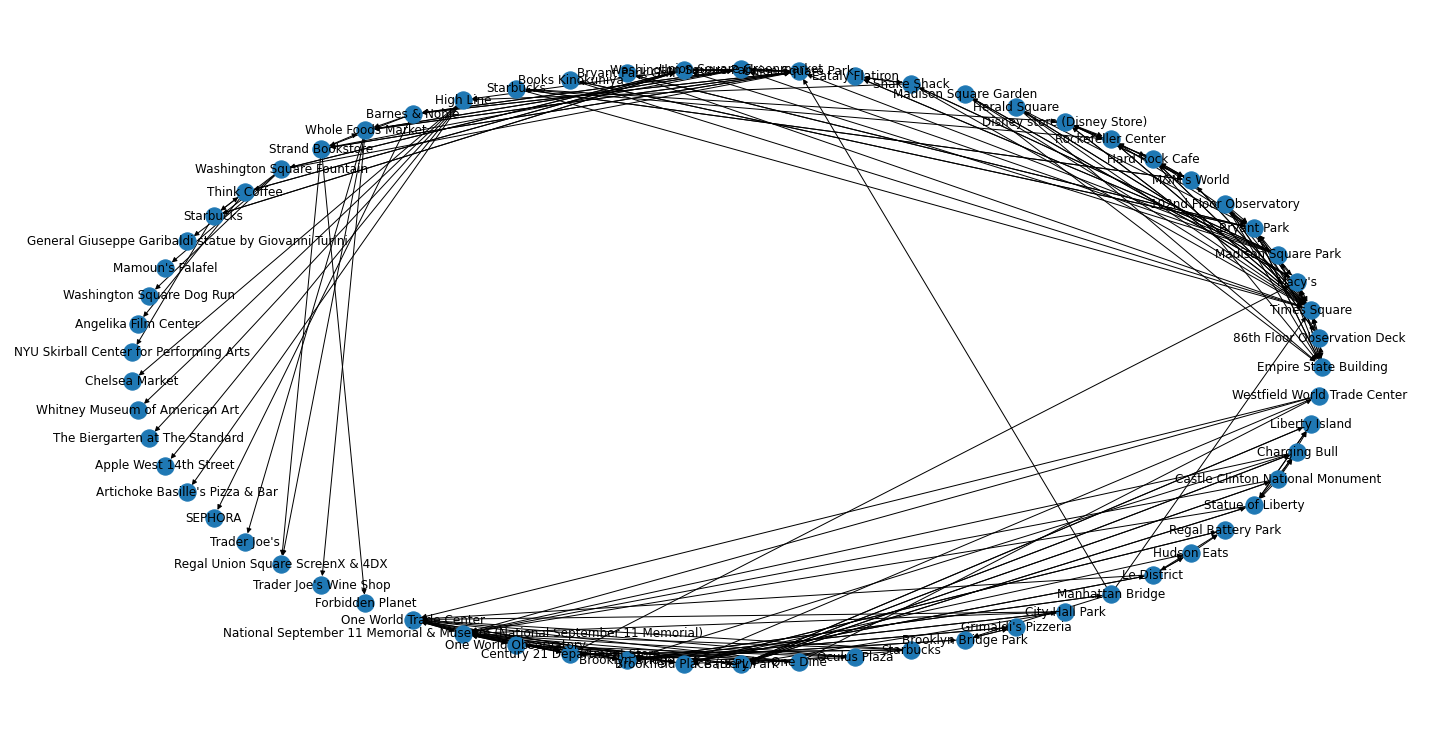

In [153]:
nx.draw_shell(g, labels=labels)

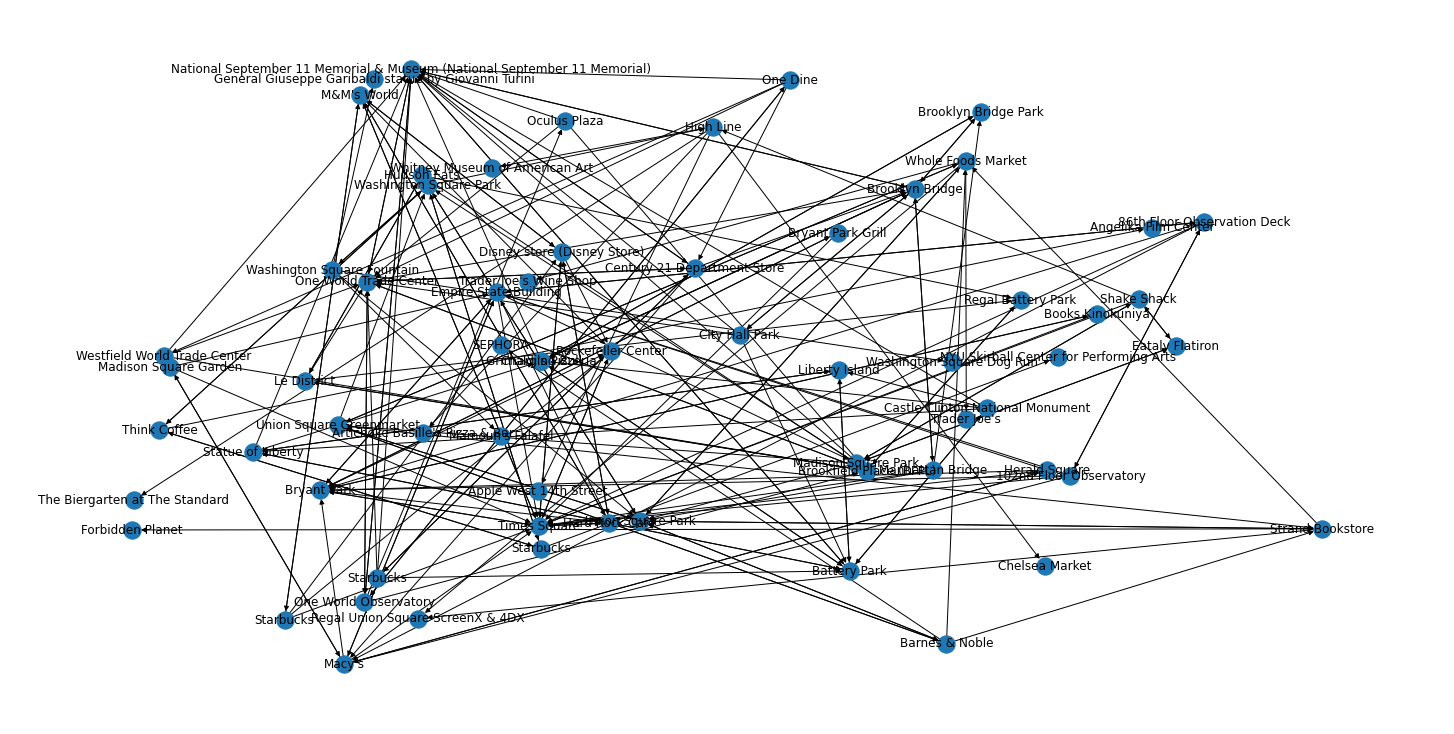

In [155]:
nx.draw_random(g, labels=labels)

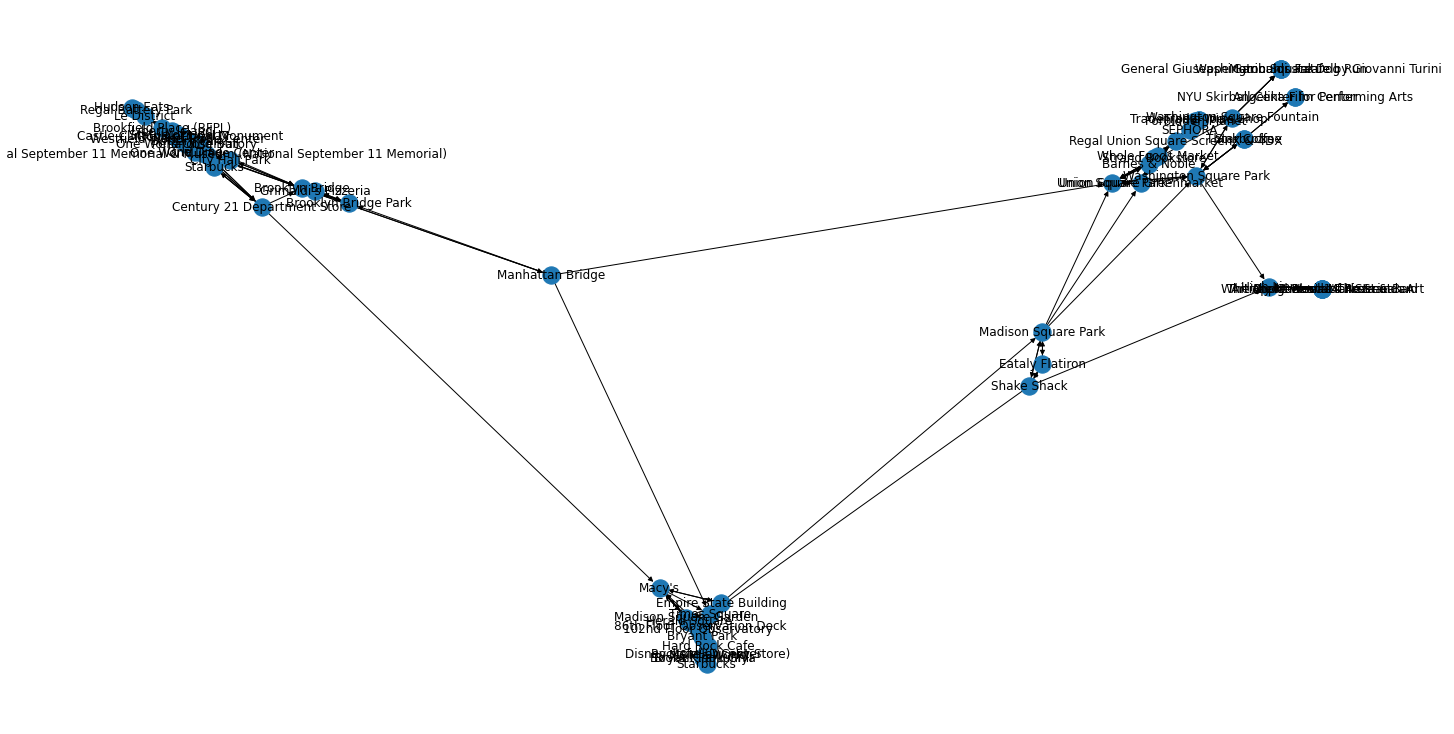

In [160]:
nx.draw_spectral(g, k = 0.9, labels=labels)